# KTRLite Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand
from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

In [3]:
print(orbit.__version__)
print(matplotlib.__version__)

1.1.0dev
3.3.4


## Data

In [22]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [7]:
ktrlite = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
    n_bootstrap_draws=1e4,
)

In [8]:
ktrlite.fit(train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f019f85b312f9bb6f21f9ec9a33c1c4 NOW.


In [9]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.94469,10.01205,10.08009,10.00878,10.01030,10.01179,0.02593,0.02593,0.02593,-0.02418,-0.02418,-0.02418
1,2008-01-03,9.94794,10.01419,10.08116,10.00725,10.01030,10.01328,0.02841,0.02841,0.02841,-0.02452,-0.02452,-0.02452
2,2008-01-04,9.96022,10.02848,10.09616,10.00572,10.01030,10.01476,0.04281,0.04281,0.04281,-0.02464,-0.02464,-0.02464
3,2008-01-05,9.88624,9.95437,10.02201,10.00419,10.01030,10.01625,-0.03141,-0.03141,-0.03141,-0.02452,-0.02452,-0.02452
4,2008-01-06,9.82772,9.89592,9.96425,10.00266,10.01030,10.01774,-0.09020,-0.09020,-0.09020,-0.02419,-0.02419,-0.02419


In [10]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.44%'

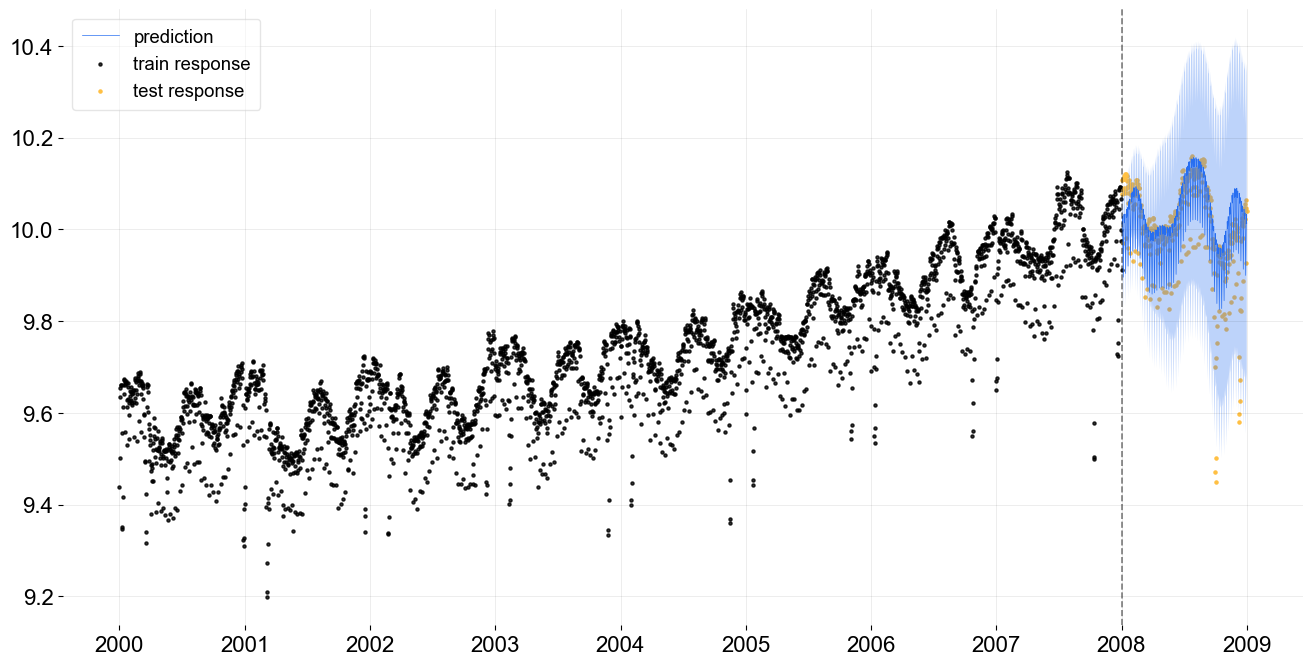

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

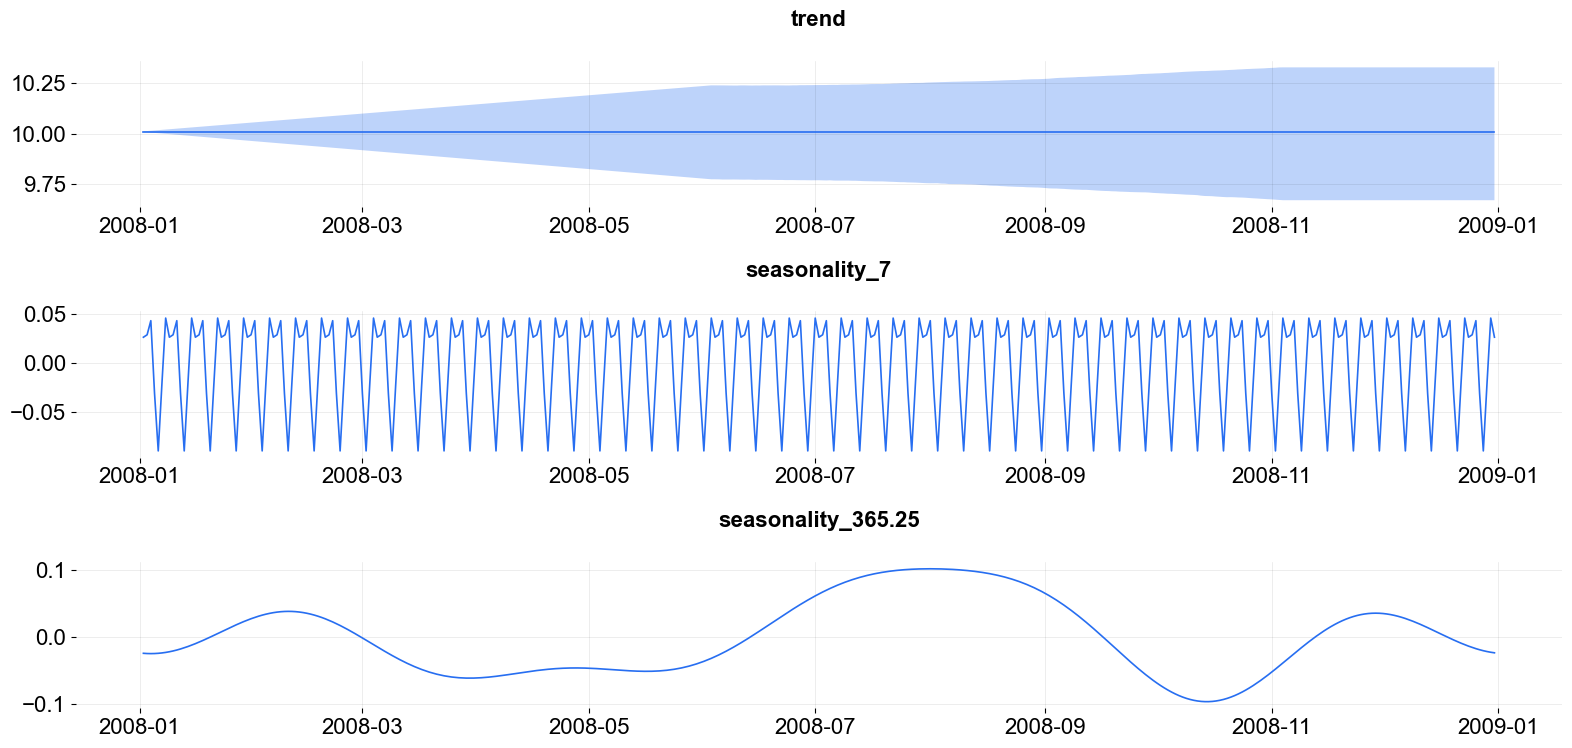

In [12]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

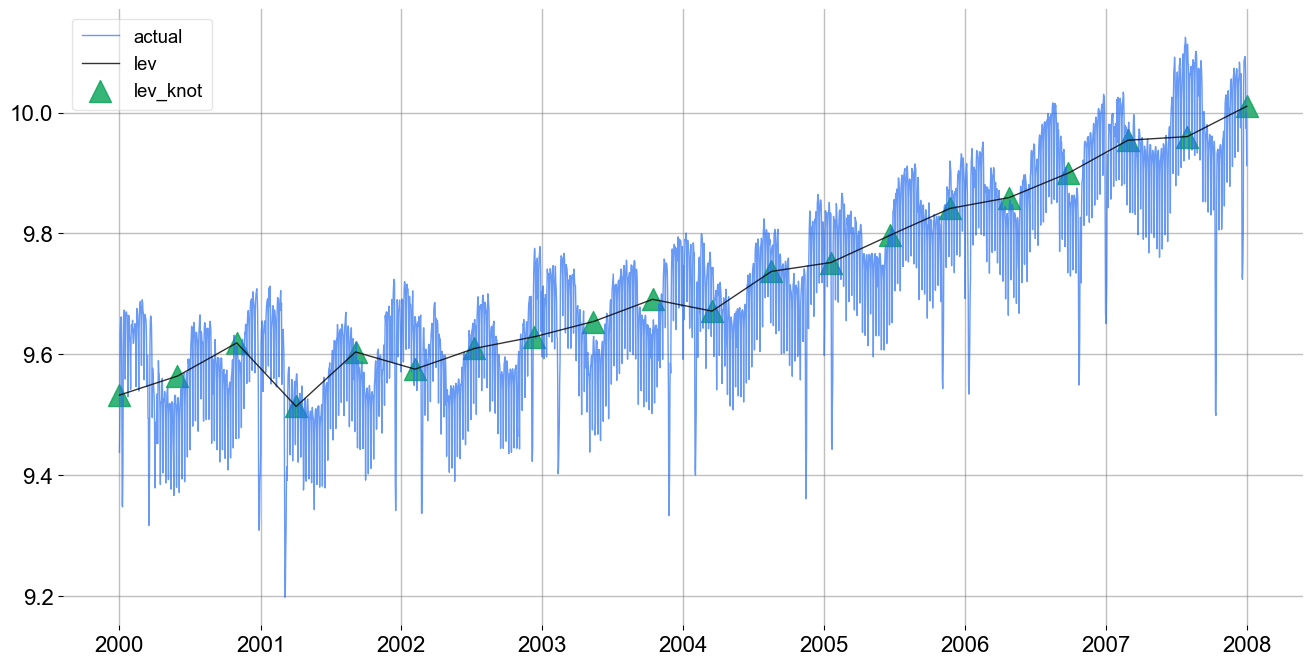

In [13]:
_ = ktrlite.plot_lev_knots()

In [14]:
ktrlite._model._level_knot_dates

array(['2000-01-01T00:00:00.000000000', '2000-05-30T00:00:00.000000000',
       '2000-10-31T00:00:00.000000000', '2001-04-03T00:00:00.000000000',
       '2001-09-04T00:00:00.000000000', '2002-02-05T00:00:00.000000000',
       '2002-07-09T00:00:00.000000000', '2002-12-10T00:00:00.000000000',
       '2003-05-13T00:00:00.000000000', '2003-10-14T00:00:00.000000000',
       '2004-03-16T00:00:00.000000000', '2004-08-17T00:00:00.000000000',
       '2005-01-18T00:00:00.000000000', '2005-06-21T00:00:00.000000000',
       '2005-11-22T00:00:00.000000000', '2006-04-25T00:00:00.000000000',
       '2006-09-26T00:00:00.000000000', '2007-02-27T00:00:00.000000000',
       '2007-07-31T00:00:00.000000000', '2008-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [15]:
lev_knots_df = ktrlite.get_level_knots()
lev_knots_df.head()

,date,lev_knot
0,2000-01-01,9.53232
1,2000-05-30,9.56367
2,2000-10-31,9.61877
3,2001-04-03,9.51353
4,2001-09-04,9.60376


# Stability Check

### Test on different seeds

In [16]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
    seed=2020
)

ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
    seed=2021
)

ktrlite1.fit(df)
ktrlite2.fit(df)

In [17]:
np.allclose(
    ktrlite1.get_point_posteriors()['map']['lev_knot'],
    ktrlite2.get_point_posteriors()['map']['lev_knot'],
    rtol=1e-3,
)

True

### Test on different segments

In [23]:
ktrlite1 = KTRLite(                   
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=18,
    seasonality_segments=2,
    estimator='stan-map',
)

ktrlite2 = KTRLite(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=19,
    seasonality_segments=2,
    estimator='stan-map',
)

ktrlite1.fit(df)
ktrlite2.fit(df)

In [25]:
ktrlite1.get_point_posteriors()['map'].get('obs_scale')

array([0.04127911])

In [26]:
ktrlite2.get_point_posteriors()['map'].get('obs_scale')

array([0.04099448])

In [28]:
np.allclose(
    ktrlite1.get_point_posteriors()['map']['obs_scale'],
    ktrlite2.get_point_posteriors()['map']['obs_scale'],
    rtol=1e-2,
)

True